In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

np.set_printoptions(suppress=True)

In [0]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

## Load the cifar dataset

In [0]:
#download data
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#labels 0,1,8,9 --->  Transport
#labels 2,3,4,5,6,7 ----> Animals
#For training data combine the 10 classes to two classes,0 for transport and 1 for animals
y_train[np.where(np.isin(y_train,[0,1,8,9]))] = 0
y_train[np.where(np.isin(y_train,[2,3,4,5,6,7]))] = 1

#two classes labels
labels = ['Transport','Animal']
#df1=pd.DataFrame(y_train, columns=['X'])
#df1.X.value_counts()

#For test data combine the 10 classes to two classes,0 for transport and 1 for animals
y_test[np.where(np.isin(y_test,[0,1,8,9]))] = 0
y_test[np.where(np.isin(y_test,[2,3,4,5,6,7]))] = 1

In [4]:
!pip install tensorboardcolab

In [5]:
import tensorboardcolab

Using TensorFlow backend.


In [6]:
tbc = tensorboardcolab.TensorBoardColab()

writer = tbc.get_writer()

Wait for 8 seconds...


W0721 01:14:24.794688 140637036910464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



TensorBoard link:
https://e12256de.ngrok.io


## Normalize the inputs and reshape the labels

In [0]:
#reshape training labels to one-hot coding
y_input = tf.keras.utils.to_categorical(y_train[:40000])

#normalise the training data
x_input = (x_train[:40000]  / 255.0)

#subset validatuon data and reshape validation labels to one-hot coding
y_valid = tf.keras.utils.to_categorical(y_train[40000:])
x_valid = (x_train[40000:] / 255.0)

#reshape test data
x_test_input = x_test / 255.0



In [0]:
#generate data batches
data_index = 0
def generate_batch(batch_size):
    global data_index
    batch = np.ndarray(shape=(batch_size, 32, 32, 3), dtype=np.float32)  #the same shapes as train data
    labels = np.ndarray(shape=(batch_size,2), dtype=np.float32)
    for i in range(batch_size):
        batch[i] = x_input[data_index]
        labels[i] = y_input[data_index]
        data_index = (data_index + 1) % len(x_input)
    return batch, labels

## Create the placeholders

In [0]:
#start_lr = 1e-10
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 2])


## Now we'll build the convolutional layer

In [10]:
# input Layer

conv_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3),activation=tf.nn.relu)(x)

flat_layer = tf.keras.layers.Flatten()(conv_layer)

dense = tf.keras.layers.Dense(units=512, activation=tf.nn.tanh)(flat_layer)

# logits Layer
y = tf.keras.layers.Dense(units=2,activation=tf.nn.softmax)(dense)

W0721 01:14:25.755122 140637036910464 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Create the loss

In [0]:
#crossentropy loss function
cost = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

## Set up the training parameters

In [12]:
lr = 0.0001
gd_train =tf.train.RMSPropOptimizer(lr).minimize(cost)
#optimizer= tf.train.AdamOptimizer(lr)
#gd_train =optimizer.minimize(cost,global_step=global_step)


W0721 01:14:25.912283 140637036910464 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
# to calculate the accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [0]:
sess = tf.Session()
writer.add_graph(sess.graph)
sess.close()

In [0]:

#
#TensorBoard summary for the validation accuracy
val_acc = tf.summary.scalar(name='val_acc', tensor=accuracy)
train_acc = tf.summary.scalar(name='train_acc', tensor=accuracy)
loss_val = tf.summary.scalar(name='loss_val', tensor=cost)
loss_train = tf.summary.scalar(name='loss_train', tensor=cost)
#learning_rate = tf.summary.scalar(name="learning_rate",tensor=lr)
#tf.summary.scalar("current_step", global_step)
#merged = tf.summary.merge_all() 


## Create a session and run the training

In [16]:
#epochs=1000
#batch_size=1024

#500 with 4096 is best
epochs=250
batch_size=128


init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)


for i in range(epochs):
  #global_step = tf.train.get_global_step()
  batch_x, batch_y = generate_batch(batch_size)
  _,train_loss, train_accuracy = sess.run([gd_train,loss_train,train_acc], feed_dict={x:batch_x, y_:batch_y})
      
   
  val_accuracy,val_loss= sess.run([val_acc,loss_val], feed_dict = { x: x_valid, y_: y_valid})
  
  #rt= sess.run(learning_rate)
  writer.add_summary(train_accuracy,i)
  writer.add_summary(val_accuracy,i)
  writer.add_summary(val_loss,i)
  writer.add_summary(train_loss,i)
  #writer.add_summary(rt,i)
  #print(sess.run(optimizer._lr))
  if i%10 == 0:
    print('Training Step:' + str(i) + '  valid_Loss = ' + str(sess.run(cost, {x: x_valid, y_: y_valid})) +  '  train_Loss = ' + str(sess.run(cost, {x: batch_x, y_: batch_y})))
    

Training Step:0  valid_Loss = 0.6993341  train_Loss = 0.70256567
Training Step:10  valid_Loss = 0.6917211  train_Loss = 0.69076073
Training Step:20  valid_Loss = 0.6815589  train_Loss = 0.70238274
Training Step:30  valid_Loss = 0.67096555  train_Loss = 0.6894671
Training Step:40  valid_Loss = 0.6577001  train_Loss = 0.67104447
Training Step:50  valid_Loss = 0.63754797  train_Loss = 0.60398585
Training Step:60  valid_Loss = 0.60696423  train_Loss = 0.6091974
Training Step:70  valid_Loss = 0.57176936  train_Loss = 0.5850903
Training Step:80  valid_Loss = 0.5531622  train_Loss = 0.52882797
Training Step:90  valid_Loss = 0.4970498  train_Loss = 0.4881536
Training Step:100  valid_Loss = 0.5821539  train_Loss = 0.5958985
Training Step:110  valid_Loss = 0.57201844  train_Loss = 0.5664508
Training Step:120  valid_Loss = 0.80079734  train_Loss = 0.80135155
Training Step:130  valid_Loss = 0.53107685  train_Loss = 0.58692956
Training Step:140  valid_Loss = 0.6094933  train_Loss = 0.48043922
Train

In [17]:
y_prob = sess.run(y, feed_dict={x: x_test_input})

print(y_prob.shape)
y_pred = np.argmax(y_prob,axis=-1)
print('test accuracy: ', np.sum(y_pred==y_test[:,0])/len(y_test))

(10000, 2)
test accuracy:  0.8397


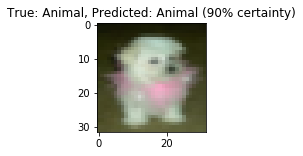

In [18]:
i=3000

label = y_test[i]
image = x_test[i]
plt.figure(figsize=(2,2))
plt.grid(False)
plt.title('True: %s, Predicted: %s (%d%% certainty)' % (labels[int(label)],labels[y_prob[i].argmax()],100*y_prob[i,y_prob[i].argmax()]))
plt.imshow(image)
plt.show()

In [0]:
sess.close()